# AutoEncoderの実装

In [42]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連 p
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cloudpickle

from utils import try_gpu

## モデル構築

In [43]:
class Encoder(nn.Module):
    def __init__(self, input_size, output_size):
        # side_size: 画像の1辺サイズ
        # output_size: 出力サイズ
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Encoder(28*28, 2)

Encoder(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)

In [44]:
class Decoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

Decoder(2, 28*28)

Decoder(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
)

In [45]:
class AutoEncoder(nn.Module):
    def __init__(self, inout_size, latent_size):
        # inout_size:inとoutのサイズ
        # latent_size:潜在空間の次元数
        super(AutoEncoder, self).__init__()
        self.inout_size = inout_size
        self.latent_size = latent_size
        self.encoder = Encoder(inout_size, latent_size)
        self.decoder = Decoder(latent_size, inout_size)
        
    def forward(self, x):
        x = x.view(-1, self.inout_size)
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def loss(self, x_hat, x):
        loss = F.binary_cross_entropy(x_hat, x.view(-1, self.inout_size), reduction='sum')
        return loss
    
    def forward_calculate_loss(self, data):
        # 1batch における loss 計算
        # data_loader から渡される mini_batch から loss を計算
        imgs, _ = data
        x = try_gpu(Variable(imgs))
        x_hat = self(x)
        return self.loss(x_hat, x)

In [46]:
from utils import init_model
model = init_model(AutoEncoder, inout_size=28*28, latent_size=2)
model

AutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=784, bias=True)
  )
)

## 学習

In [47]:
from utils import make_dataset_loader, run_train_test

In [48]:
# train settings
model_name = 'ae'
num_epochs = 100
batch_size = 256
learning_rate = 1e-3
model = init_model(AutoEncoder, inout_size=28*28, latent_size=2)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# data download
task_name = 'mnist'
load_func = torchvision.datasets.MNIST
train_dataset_loader, test_dataset_loader = make_dataset_loader(batch_size, load_func)

loaded <class 'torchvision.datasets.mnist.MNIST'> train:60000, test:10000


In [49]:
trained_dict = run_train_test(model, model_name, task_name, optimizer, num_epochs, train_dataset_loader, test_dataset_loader)

make dir ./runs/mnist/ae/20191106T172704, ./models/mnist/ae/20191106T172704
epoch [1/100], step:235, loss:232.0218, test_loss:189.8755, {'elapsed': '5秒', 'remain': '9分53秒'}
model save to ./models/mnist/ae/20191106T172704/epoch001.pt
epoch [2/100], step:470, loss:180.3015, test_loss:171.2501, {'elapsed': '11秒', 'remain': '9分30秒'}
model save to ./models/mnist/ae/20191106T172704/epoch002.pt
epoch [3/100], step:705, loss:167.1550, test_loss:162.8511, {'elapsed': '17秒', 'remain': '9分32秒'}
model save to ./models/mnist/ae/20191106T172704/epoch003.pt
epoch [4/100], step:940, loss:160.0842, test_loss:157.3170, {'elapsed': '23秒', 'remain': '9分22秒'}
model save to ./models/mnist/ae/20191106T172704/epoch004.pt
epoch [5/100], step:1175, loss:155.7696, test_loss:153.6293, {'elapsed': '29秒', 'remain': '9分11秒'}
model save to ./models/mnist/ae/20191106T172704/epoch005.pt
epoch [6/100], step:1410, loss:152.7374, test_loss:151.5143, {'elapsed': '34秒', 'remain': '9分4秒'}
model save to ./models/mnist/ae/2019

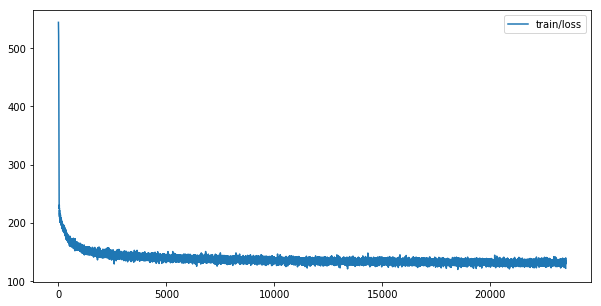

In [50]:
from utils import extract_scalar_from_event, plot_from_dict

scalar_dict = extract_scalar_from_event(trained_dict['log_dir'])
plt.figure(figsize=(10, 5))
plot_from_dict(scalar_dict, 'train/loss')

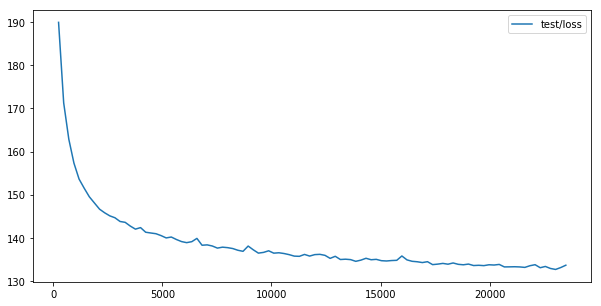

In [51]:
plt.figure(figsize=(10, 5))
plot_from_dict(scalar_dict, 'test/loss')

## デコード出力描画

epochごとの学習具合を確認

In [52]:
from utils import load_model, plot_gray_img

In [ ]:
def output_shaped(model, imgs):
    # いい感じで整形して出力
    size = int(np.sqrt(model.inout_size))
    output = model(try_gpu(imgs.view(-1, size*size)))
    return output.view(-1, 1, size, size).cpu().data

In [53]:
from glob import glob
model_path_list = glob(f'{trained_dict["model_dir"]}/*.pt')
model_path_list = sorted(model_path_list)

In [54]:
model = load_model(model_path_list[-1])

In [55]:
model

AutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=784, bias=True)
  )
)

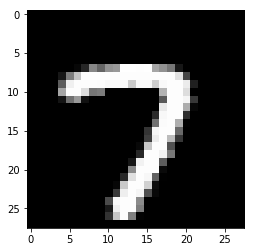

In [56]:
_imgs, _labels = iter(test_dataset_loader).next()
_input_img = _imgs[0].view(28, 28)
plot_gray_img(_input_img)

CPU times: user 41.9 ms, sys: 20.9 ms, total: 62.7 ms
Wall time: 20 ms


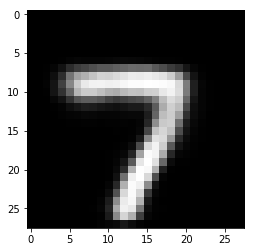

In [57]:
%%time
_output_img = output_shaped(model, _input_img).view(28, 28)
plot_gray_img(_output_img)

In [58]:
from utils import plot_img_grid

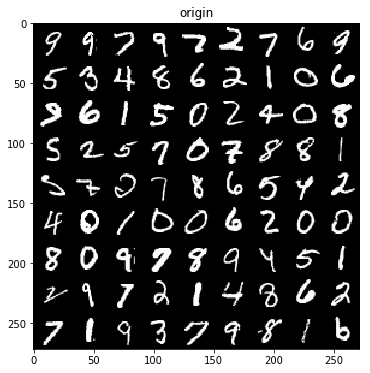

In [60]:
_input_imgs = iter(test_dataset_loader).next()[0][:9*9]
decode_dir = f'./decode/{task_name}/{model_name}'
os.makedirs(decode_dir)
plot_img_grid(_input_imgs, 9, f'{decode_dir}/origin.png', 'origin')

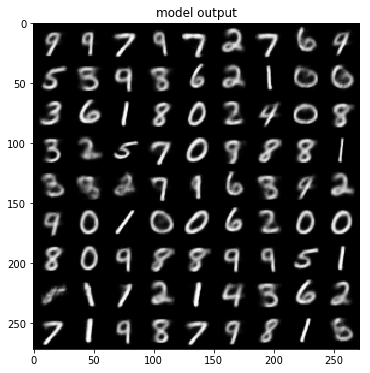

In [61]:
# 最後のモデルの出力
latest_model_output = output_shaped(model, _input_imgs)
plot_img_grid(latest_model_output, 9, title='model output')

一気に出力

In [ ]:
import re
import os
from tqdm import tqdm
for model_path in tqdm(model_path_list):
    model = load_model(model_path)
    output = output_shaped(model, _input_imgs)
    epoch = re.sub("\\D", "", os.path.basename(model_path))
    plot_img_grid(output, title=f'epoch: {epoch}', save_path=f'./decode/mnist/{model_name}/epoch{epoch}.png', nrow=9)

インタラクティブに見てみる

UIががたつくのであんまりよくない

In [63]:
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
# import os

In [ ]:
# %matplotlib inline
# def plot_interactive(epoch):
#     # インタラクティブに描画してみる
#     model_path = f'./models/mnist/ae/epoch{epoch:03}.pt'
#     if os.path.exists(model_path):
#         output = load_model_output(model_path, imgs_scaled)
#         plot_img_99(output, title=f'epoch: {epoch}')
#     else:
#         print(f'{model_path} is not found.')
#         plot_img_99(imgs_scaled.view(-1, 1, 28, 28).cpu().data, title=f'origin')

# # interact(plot_interactive, epoch=widgets.IntSlider(min=0, max=len(model_path_list), step=1, value=0));

Gifにする

In [64]:
from PIL import Image, ImageDraw

In [65]:
git_output_path = f'./decode/{task_name}/{model_name}/model_outputs.gif'
images = [Image.open(img_path) for img_path in sorted(glob(f'./decode/{task_name}/{model_name}/*.png'))]
images[0].save(git_output_path, save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)
git_output_path

'./decode/mnist/ae/model_outputs.gif'

## 潜在空間の分布

せっかく2次元まで圧縮したので分布を確認する

In [66]:
model = load_model(model_path_list[-1])

In [67]:
from tqdm import tqdm
label_xy_list = [[] for _ in range(10)]
for img, label in tqdm(test_dataset_loader.dataset):
    xy = model.encoder(try_gpu(img.view(-1, 28*28))).view(2).cpu().data
    label_xy_list[label].append(xy.numpy())

100%|██████████| 10000/10000 [00:09<00:00, 1065.49it/s]


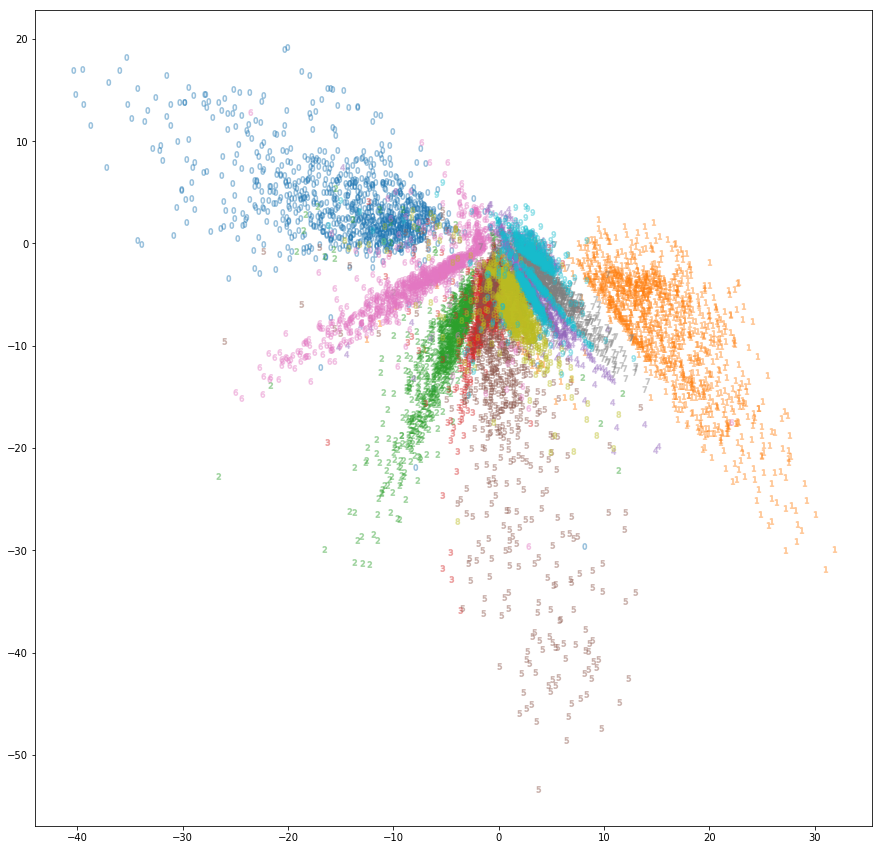

In [68]:
def plot_encoded_space(ax=None):
    if ax is None:
        ax = plt
        ax.figure(figsize=(15, 15))
    for label in range(10):
        xy_arr = np.array(label_xy_list[label])
        ax.plot(xy_arr[:,0], xy_arr[:,1], '.', marker="${}$".format(label), label=label, alpha=0.3)

plot_encoded_space()

## 潜在空間を指定して生成

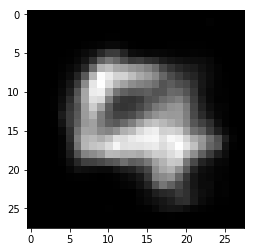

In [69]:
model = load_model(model_path_list[-1])
output = model.decoder((try_gpu(torch.tensor([0, 0]).float()))).view(1, 784)
plot_gray_img(output.view(28, 28).cpu().data)

In [70]:
import itertools
xy_list = list(itertools.product(np.arange(-30, 20, 50/40), np.arange(-30, 20, 50/40)))
xy_list = sorted(xy_list, key=lambda x: x[1], reverse=True)
xy_list = try_gpu(torch.tensor(xy_list, dtype=torch.float))

In [71]:
# 40*40の画像をまとめてplot
import math
outputs = model.decoder(xy_list)
output_imgs = outputs.view(-1, 1, 28, 28)
nrow = int(math.sqrt(output_imgs.size(0)))
imgs = torchvision.utils.make_grid(output_imgs, nrow=nrow, normalize=True)[0]
nrow

40

In [72]:
output_imgs.shape

torch.Size([1600, 1, 28, 28])

CPU times: user 2.57 s, sys: 341 ms, total: 2.91 s
Wall time: 2.39 s


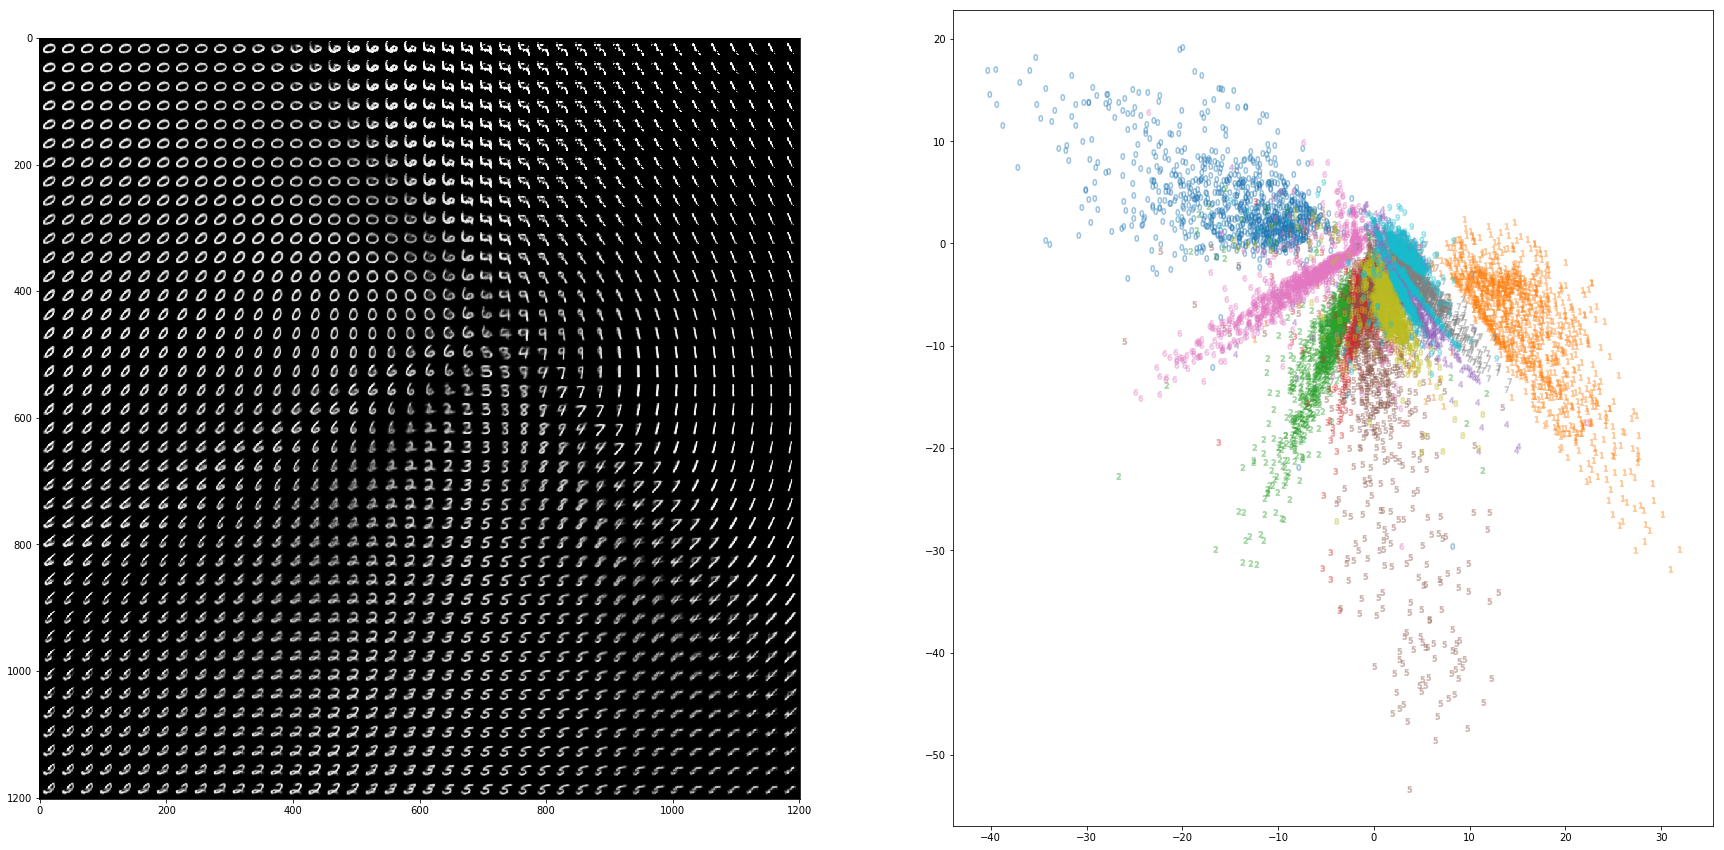

In [73]:
%%time
fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
plot_gray_img(imgs.cpu().data, ax1)
plot_encoded_space(ax2)
plt.savefig(f'./decode/{task_name}/{model_name}/model_output_dist.png', dpi=150)